<a href="https://colab.research.google.com/github/Gabriele90/ML-for-histopathology/blob/main/Breast%20cancer%20histolopathology%20using%20DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Introduction***

Today, medical image analysis papers require solid
experiments to prove the usefulness of proposed methods. However,
experiments are often performed on data selected by the
researchers, which may come from different institutions, scanners
and populations. Different evaluation measures may be used,
making it difficult to compare the methods. Diagnosis from a histopathology image is the gold standard in diagnosing almost all types of cancer, including Breast Cancer.
Histopathological analysis is a highly, time consuming specialized
task, dependent on the experience of the pathologists
and influenced by factors such as fatigue and decrease of
attention.

**Objectives**

In this paper, I utilized a dataset of 7,909 breast cancer (BC) histopathology images acquired on 82 patients, that is now publicly available from http://web.inf.ufpr.br/vri/breast-cancer-database. The dataset includes both benign and malignant images. The task associated to this dataset is the automated classification of these images in two classes, which would be a valuable computer aided diagnosis tool for the clinician.

I decided to use and compare two deep neural networks for this task: ResNet and InceptionV3.
The model that achieved  great accuracies both for the training and validaytion dateset was ResNet (100% and 90% respectively),showing room for improvement is left.

**Dataset decrition**

The selected database, called BreaKHis, is composed
of 7,909 clinically representative, microscopic images of breast
tumor tissue images collected from 82 patients using different
magnifying factors (40×, 100×, 200×, and 400×). To date,
it contains 2,480 benign and 5,429 malignant samples. This
database has been built in collaboration with the P&D Laboratory
1 – Pathological Anatomy and Cytopathology, Parana,
Brazil.

The dataset currently
contains four histological distinct types of benign breast tumors:
adenosis (A), fibroadenoma (F), phyllodes tumor (PT),
and tubular adenona (TA); and four malignant tumors (breast
cancer): carcinoma (DC), lobular carcinoma (LC), mucinous
carcinoma (MC) and papillary carcinoma (PC).

***Import Libraries***

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from tensorflow.keras.metrics import Metric

from typeguard import typechecked
from typing import Optional
import cv2
import random
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as numpy
import matplotlib.pyplot as pyplot
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

**GPU setting**

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Mar 16 08:33:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

***Clone & Explore dataset***

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#set the path to the main dir
import os
main_dir = "/content/drive/MyDrive/BreaKHis 400X"
#set the path to the train dir
train_dir = os.path.join(main_dir,'train')
#set the path to the test dir
test_dir = os.path.join(main_dir,'test')
#directory with the training benign images
train_benign_dir = os.path.join(train_dir, 'benign')
#directory with the training malignant images
train_malignant_dir = os.path.join(train_dir, 'malignant')
#directory with the testing benign images
test_benign_dir = os.path.join(test_dir, 'benign')
#directory with the testing malignant images
test_malignant_dir = os.path.join(test_dir, 'malignant')

In [6]:
#print the filenames
train_benign_names = os.listdir(train_benign_dir)
print(train_benign_names[:10])

train_malignant_names = os.listdir(train_malignant_dir)
print(train_malignant_names[:10])

test_benign_names = os.listdir(test_benign_dir)
print(test_benign_names[:10])

test_malignant_names = os.listdir(test_malignant_dir)
print(test_malignant_names[:10])

['SOB_B_A-14-22549AB-400-008.png', 'SOB_B_A-14-22549AB-400-002.png', 'SOB_B_A-14-22549AB-400-012.png', 'SOB_B_A-14-22549AB-400-009.png', 'SOB_B_A-14-22549AB-400-014.png', 'SOB_B_A-14-22549AB-400-013.png', 'SOB_B_A-14-22549AB-400-006.png', 'SOB_B_A-14-22549CD-400-002.png', 'SOB_B_A-14-22549AB-400-021.png', 'SOB_B_A-14-22549CD-400-015.png']
['SOB_M_DC-14-11031-400-004.png', 'SOB_M_DC-14-11031-400-009.png', 'SOB_M_DC-14-10926-400-008.png', 'SOB_M_DC-14-11031-400-007.png', 'SOB_M_DC-14-11031-400-010.png', 'SOB_M_DC-14-10926-400-007.png', 'SOB_M_DC-14-11031-400-001.png', 'SOB_M_DC-14-11031-400-002.png', 'SOB_M_DC-14-10926-400-006.png', 'SOB_M_DC-14-10926-400-002.png']
['SOB_B_A-14-22549CD-400-009.png', 'SOB_B_A-14-22549AB-400-015.png', 'SOB_B_A-14-22549AB-400-011.png', 'SOB_B_A-14-22549AB-400-028.png', 'SOB_B_A-14-22549AB-400-019.png', 'SOB_B_A-14-22549CD-400-006.png', 'SOB_B_A-14-22549CD-400-029.png', 'SOB_B_A-14-22549CD-400-014.png', 'SOB_B_A-14-22549CD-400-018.png', 'SOB_B_A-14-22549AB-4

In [7]:
#print the total no of images present in each dir
print("Total images in the training set:", len(train_benign_names+train_malignant_names))
print("Total images in the test set:", len(test_benign_names+test_malignant_names))

Total images in the training set: 1148
Total images in the test set: 545


***Data Visualization***

In [8]:
#get the filenames from the covid & normal dir of the train dataset
benign_pic =[os.path.join(train_benign_dir, filename) for filename in train_benign_names[0:8]]
malignant_pic =[os.path.join(train_malignant_dir, filename) for filename in train_malignant_names[0:8]]
#print the list
print(benign_pic)
print(malignant_pic)

['/content/drive/MyDrive/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-008.png', '/content/drive/MyDrive/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-002.png', '/content/drive/MyDrive/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-012.png', '/content/drive/MyDrive/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-009.png', '/content/drive/MyDrive/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-014.png', '/content/drive/MyDrive/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-013.png', '/content/drive/MyDrive/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-006.png', '/content/drive/MyDrive/BreaKHis 400X/train/benign/SOB_B_A-14-22549CD-400-002.png']
['/content/drive/MyDrive/BreaKHis 400X/train/malignant/SOB_M_DC-14-11031-400-004.png', '/content/drive/MyDrive/BreaKHis 400X/train/malignant/SOB_M_DC-14-11031-400-009.png', '/content/drive/MyDrive/BreaKHis 400X/train/malignant/SOB_M_DC-14-10926-400-008.png', '/content/drive/MyDrive/BreaKHis 400X/train/malignant/SOB_M_DC-14-11

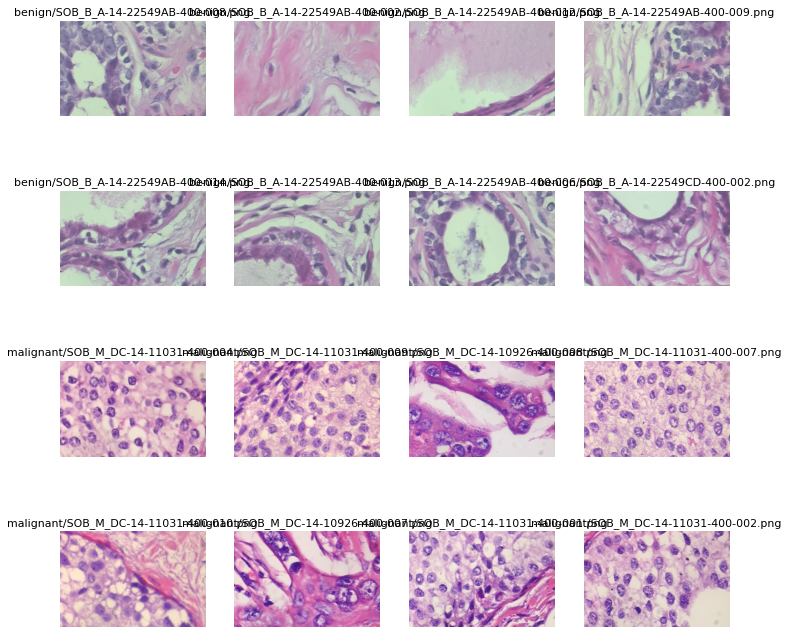

In [9]:
import matplotlib.pyplot as plt
# plot a grid of 16 images (8 images of Benign and 8 images of Malignant)
import matplotlib.image as mpimg
#set the number of columns and rows
rows = 4
cols = 4
#set the figure size
fig = plt.gcf()
fig.set_size_inches(12,12)
#merge the covid and normal list
merged_list = benign_pic+malignant_pic
for i , img_path in enumerate(merged_list):
  data= img_path.split('/', 6)[6]
  sp = plt.subplot(rows, cols, i + 1 )
  sp.axis('Off')
  img = mpimg.imread(img_path)
  sp.set_title(data, fontsize=11)
  plt.imshow(img,cmap='gray')

  plt.show

In [39]:
x = []
y = []

for i in tqdm(os.listdir(train_benign_dir)):
    path = os.path.join(train_benign_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('BENIGN')

for i in tqdm(os.listdir(train_malignant_dir)):
    path = os.path.join(train_malignant_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('MALIGNANT')

100%|██████████| 777/777 [00:09<00:00, 79.98it/s]


In [40]:
for i in tqdm(os.listdir(test_benign_dir)):
    path = os.path.join(test_benign_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('BENIGN')

for i in tqdm(os.listdir(test_malignant_dir)):
    path = os.path.join(test_malignant_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('MALIGNANT')

100%|██████████| 369/369 [00:04<00:00, 78.98it/s]


In [41]:
x = np.array(x)
y = np.array(y)
x.shape,y.shape

((1693, 150, 150, 3), (1693,))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


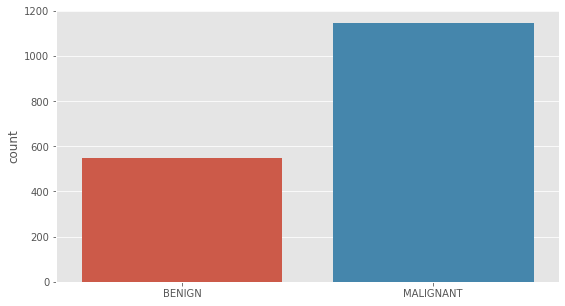

In [42]:
import seaborn as sns
plt.style.use("ggplot")
plt.figure(figsize=(9,5))
sns.countplot(y)
plt.show()

In [43]:
y

array(['BENIGN', 'BENIGN', 'BENIGN', ..., 'MALIGNANT', 'MALIGNANT',
       'MALIGNANT'], dtype='<U9')

In [44]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

In [45]:
y = to_categorical(y)#num_classes = 2
y.shape

(1693, 2)

In [46]:
from sklearn.utils import shuffle
x,y = shuffle(x,y)

In [47]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [48]:
y_test.shape

(339, 2)

***Data Preprocessing & Augmentation***

Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks.

In [10]:
# generate training,testing and validation batches 
dgen_train = ImageDataGenerator(rescale =1./255,
                                validation_split=0.2,
                                zoom_range = 0.2,
                                horizontal_flip =True)
dgen_validation = ImageDataGenerator(rescale = 1./255)
dgen_test = ImageDataGenerator(rescale =1./255)

train_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=(150,150),
                                                 subset='training',
                                                 batch_size = 32,
                                                 class_mode = 'binary')

validation_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=(150,150),
                                                 subset='validation',
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_generator = dgen_test.flow_from_directory(test_dir,
                                                 target_size=(150,150),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 919 images belonging to 2 classes.
Found 229 images belonging to 2 classes.
Found 545 images belonging to 2 classes.


In [11]:
#get the class indices
train_generator.class_indices

{'benign': 0, 'malignant': 1}

In [12]:
#get the image shape
train_generator.image_shape

(150, 150, 3)

**Pre-Trained Model : InceptionV3**

Inceptionv3 is a convolutional neural network for assisting in image analysis and object detection, and got its start as a module for Googlenet. It is the third edition of Google's Inception Convolutional Neural Network, originally introduced during the ImageNet Recognition Challenge. Just as ImageNet can be thought of as a database of classified visual objects, Inception helps classification of objects in the world of computer vision. One such use is in life sciences, where it aids in the research of Leukemia.

In [13]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [14]:
base_model = InceptionV3(input_shape=(150,150,3), 
                   include_top=False,
                   weights="imagenet")

87916544/87910968 [==============================] - 1s 0us/step


In [15]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [55]:
model_1=Sequential()
model_1.add(base_model)
model_1.add(Dropout(0.5))
model_1.add(tf.keras.layers.GlobalAveragePooling2D())
model_1.add(Flatten())
model_1.add(BatchNormalization())
model_1.add(Dense(64,kernel_initializer='he_uniform'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(64,kernel_initializer='he_uniform'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(64,kernel_initializer='he_uniform'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(32,kernel_initializer='he_uniform'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(32,kernel_initializer='he_uniform'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dense(2,activation='sigmoid'))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_100 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                131136    
_________________________________________________________________
batch_normalization_101 (Bat (None, 64)               

**Resnet**

A residual neural network (ResNet) is an artificial neural network (ANN) of a kind that builds on constructs known from pyramidal cells in the cerebral cortex. Residual neural networks do this by utilizing skip connections, or shortcuts to jump over some layers. Typical ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between. An additional weight matrix may be used to learn the skip weights; these models are known as HighwayNets. Models with several parallel skips are referred to as DenseNets. In the context of residual neural networks, a non-residual network may be described as a plain network.

In [56]:
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50

In [57]:
res_model = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (150,150,3))
for layer in res_model.layers:
  layer.trainable = False

In [58]:
from tensorflow.keras import datasets, layers, models, losses, Model

In [59]:
x = layers.Flatten()(res_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(2, activation = 'sigmoid')(x)

In [60]:
model_2 = Model(inputs = res_model.input, outputs = predictions)

***Compile & Train the 2 Models***

To amplify our understanding of the modekl and their performance, we assessed different metrics: loss function, accuracy, precision, recall anmd F1 scores.

In [61]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [62]:
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [63]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [64]:
from tensorflow.keras.optimizers import Adam

In [65]:
#compile the Inception V3 model
model_1.compile(Adam(lr=0.001),loss='binary_crossentropy',metrics=METRICS)

In [66]:
checkpoint = ModelCheckpoint( "InceptionV3" ,monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
checkpoint_2 = ModelCheckpoint( "ResNet" ,monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [67]:
#train the Inception V3 model

history_1 = model_1.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100, 
                        validation_data=(x_test, y_test),
                        callbacks=checkpoint)

Epoch 1/100
43/43 [==============================] - 9s 83ms/step - loss: 0.7833 - accuracy: 0.5191 - precision: 0.5409 - recall: 0.2566 - auc: 0.5211 - f1_score: 0.3462 - val_loss: 0.7441 - val_accuracy: 0.4454 - val_precision: 0.4226 - val_recall: 0.2979 - val_auc: 0.4840 - val_f1_score: 0.3420

Epoch 00001: val_accuracy improved from -inf to 0.44543, saving model to InceptionV3
INFO:tensorflow:Assets written to: InceptionV3/assets
Epoch 2/100
43/43 [==============================] - 2s 36ms/step - loss: 0.6953 - accuracy: 0.5792 - precision: 0.6145 - recall: 0.4213 - auc: 0.6193 - f1_score: 0.4956 - val_loss: 0.6410 - val_accuracy: 0.6431 - val_precision: 0.6690 - val_recall: 0.5664 - val_auc: 0.6993 - val_f1_score: 0.6082

Epoch 00002: val_accuracy improved from 0.44543 to 0.64307, saving model to InceptionV3
INFO:tensorflow:Assets written to: InceptionV3/assets
Epoch 3/100
43/43 [==============================] - 2s 37ms/step - loss: 0.6697 - accuracy: 0.6197 - precision: 0.6358 -

In [68]:
#compile the ResNet model
model_2.compile(Adam(lr=0.001),loss='binary_crossentropy',metrics=METRICS)

In [69]:
#train the ResNet model
history_2 = model_2.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100, 
                        validation_data=(x_test, y_test),
                        callbacks=checkpoint_2)

Epoch 1/100
43/43 [==============================] - 15s 168ms/step - loss: 17.3081 - accuracy: 0.6861 - precision: 0.6826 - recall: 0.6966 - auc: 0.7311 - f1_score: 0.6798 - val_loss: 0.9171 - val_accuracy: 0.8761 - val_precision: 0.8632 - val_recall: 0.8938 - val_auc: 0.9179 - val_f1_score: 0.8749

Epoch 00001: val_accuracy improved from -inf to 0.87611, saving model to ResNet
INFO:tensorflow:Assets written to: ResNet/assets
Epoch 2/100
43/43 [==============================] - 4s 99ms/step - loss: 0.4049 - accuracy: 0.9310 - precision: 0.9342 - recall: 0.9272 - auc: 0.9667 - f1_score: 0.9306 - val_loss: 0.7979 - val_accuracy: 0.8392 - val_precision: 0.8363 - val_recall: 0.8437 - val_auc: 0.9040 - val_f1_score: 0.8378

Epoch 00002: val_accuracy did not improve from 0.87611
Epoch 3/100
43/43 [==============================] - 4s 99ms/step - loss: 0.1366 - accuracy: 0.9630 - precision: 0.9608 - recall: 0.9657 - auc: 0.9874 - f1_score: 0.9635 - val_loss: 0.6641 - val_accuracy: 0.8968 - v

***Model Performance Evaluation***

In [70]:
#get the keys of history object

history_1.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_f1_score'])

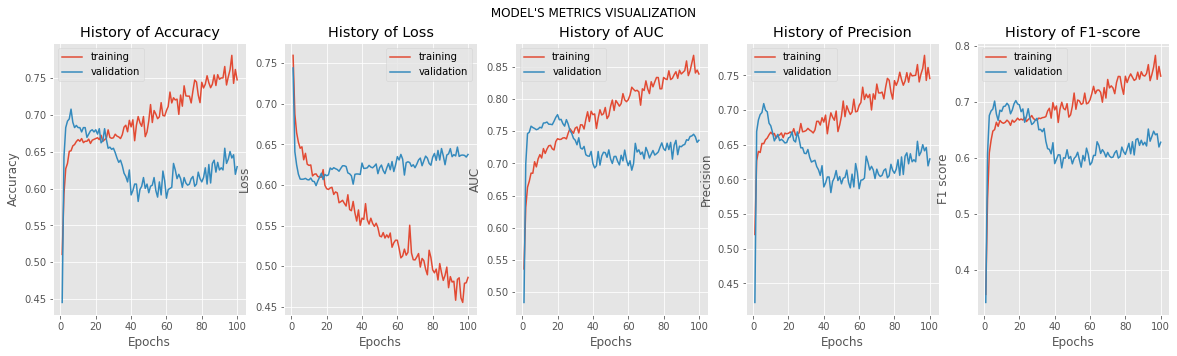

In [71]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
  fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
  fig.suptitle(" MODEL'S METRICS VISUALIZATION ")
  ax1.plot(range(1, len(acc) + 1), acc)
  ax1.plot(range(1, len(val_acc) + 1), val_acc)
  ax1.set_title('History of Accuracy')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.legend(['training', 'validation'])
  ax2.plot(range(1, len(loss) + 1), loss)
  ax2.plot(range(1, len(val_loss) + 1), val_loss)
  ax2.set_title('History of Loss')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.legend(['training', 'validation'])
    
  ax3.plot(range(1, len(auc) + 1), auc)
  ax3.plot(range(1, len(val_auc) + 1), val_auc)
  ax3.set_title('History of AUC')
  ax3.set_xlabel('Epochs')
  ax3.set_ylabel('AUC')
  ax3.legend(['training', 'validation'])

  ax4.plot(range(1, len(precision) + 1), precision)
  ax4.plot(range(1, len(val_precision) + 1), val_precision)
  ax4.set_title('History of Precision')
  ax4.set_xlabel('Epochs')
  ax4.set_ylabel('Precision')
  ax4.legend(['training', 'validation'])
    
  ax5.plot(range(1, len(f1) + 1), f1)
  ax5.plot(range(1, len(val_f1) + 1), val_f1)
  ax5.set_title('History of F1-score')
  ax5.set_xlabel('Epochs')
  ax5.set_ylabel('F1 score')
  ax5.legend(['training', 'validation'])


  plt.show()

Train_Val_Plot(history_1.history['accuracy'],history_1.history['val_accuracy'],
                 history_1.history['loss'],history_1.history['val_loss'],
                 history_1.history['auc'],history_1.history['val_auc'],
                 history_1.history['precision'],history_1.history['val_precision'],
                 history_1.history['f1_score'],history_1.history['val_f1_score']
                 )  

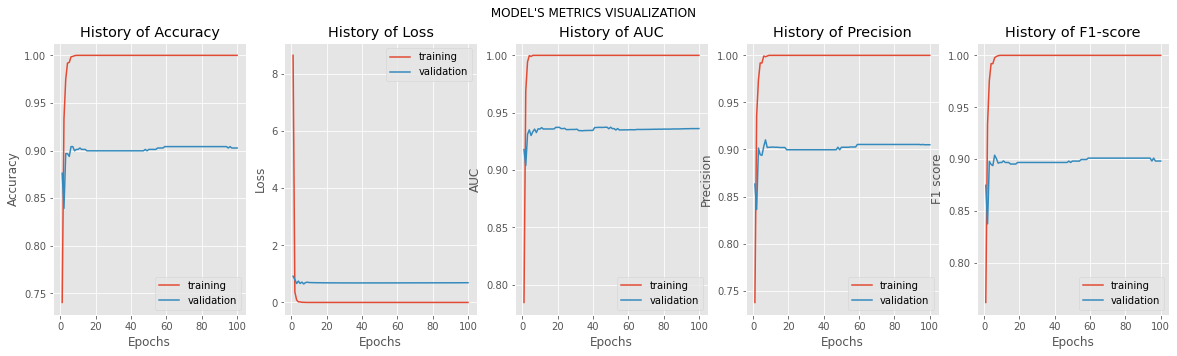

In [72]:
Train_Val_Plot(history_2.history['accuracy'],history_2.history['val_accuracy'],
                 history_2.history['loss'],history_2.history['val_loss'],
                 history_2.history['auc'],history_2.history['val_auc'],
                 history_2.history['precision'],history_2.history['val_precision'],
                 history_2.history['f1_score'],history_2.history['val_f1_score']
                 )  

**Assessing performance scores**

In [82]:
print('InceptionV3 accuracy:', history_1.history['accuracy'][-1])
print('InceptionV3 validation accuracy:', history_1.history['val_accuracy'][-1])
print('InceptionV3 loss:', history_1.history['loss'][-1])
print('InceptionV3 validation loss:', history_1.history['val_loss'][-1])

InceptionV3 accuracy: 0.7477843165397644
InceptionV3 validation accuracy: 0.6297935247421265
InceptionV3 loss: 0.48612478375434875
InceptionV3 validation loss: 0.6375921368598938


In [83]:
print('ResNet accuracy:', history_2.history['accuracy'][-1])
print('ResNet validation accuracy:', history_2.history['val_accuracy'][-1])
print('ResNet loss:', history_2.history['loss'][-1])
print('ResNet validation loss:', history_2.history['val_loss'][-1])

ResNet accuracy: 1.0
ResNet validation accuracy: 0.9026548862457275
ResNet loss: 6.31630382486037e-06
ResNet validation loss: 0.6906908750534058


As we can see, the two models present good accuracies. In particular the  ResNet model has the best accuracy and loss values.

In [85]:
y_pred= model_1.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)
unique,counts = np.unique(y_pred,return_counts=True)
print(unique,counts)
y_test_new = np.argmax(y_test,axis=1)

[0 1] [183 156]


In [87]:
y_pred_1 = model_2.predict(x_test)
y_pred_1 = np.argmax(y_pred_1,axis=1)
unique_1,counts_1 = np.unique(y_pred_1,return_counts=True)
print(unique_1,counts_1)
y_test_new_1 = np.argmax(y_test,axis=1)

[0 1] [ 96 243]


In [79]:
from sklearn.metrics import classification_report,confusion_matrix

In [86]:
clf_report = classification_report(y_test_new,y_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.43      0.79      0.55        99
           1       0.87      0.56      0.68       240

    accuracy                           0.63       339
   macro avg       0.65      0.68      0.62       339
weighted avg       0.74      0.63      0.64       339



In [88]:
clf_report_1 = classification_report(y_test_new_1,y_pred_1)
print(clf_report_1)

              precision    recall  f1-score   support

           0       0.84      0.82      0.83        99
           1       0.93      0.94      0.93       240

    accuracy                           0.90       339
   macro avg       0.88      0.88      0.88       339
weighted avg       0.90      0.90      0.90       339



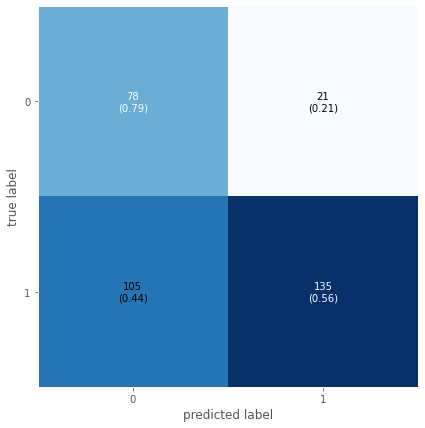

In [89]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test_new,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),
                     show_normed=True);

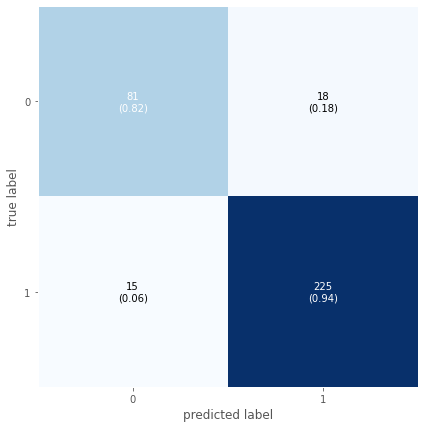

In [91]:
cm_1 = confusion_matrix(y_test_new_1,y_pred_1)
plot_confusion_matrix(conf_mat = cm_1,figsize=(8,7),
                     show_normed=True);

As we can see, ResNet is able to predict Malignant tissue with a 94% of Recall and Benign tissue with 81% of Recall.

***Model Performance***

We use the best model, in this case ResNet model, for predicting on new data.

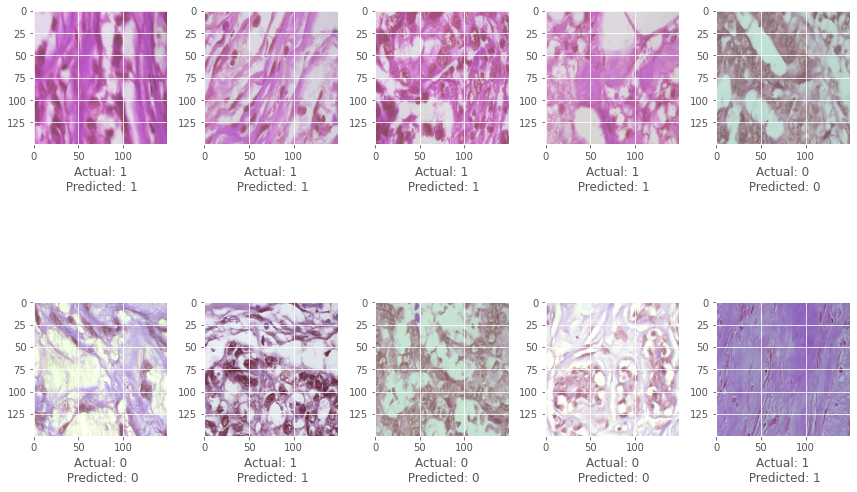

In [93]:
plt.figure(figsize=(12,9))
for i in range(10):
    sample_idx = random.choice(range(len(x_test)))
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[sample_idx])
    plt.xlabel(f"Actual: {y_test_new_1 [sample_idx]}\n Predicted: {y_pred_1 [sample_idx]}")
    
plt.tight_layout()
plt.show()